# Brain Tumor Detection
The objective is to build a deep convolutional neural network that can classify brain image scans based on whether or not a tumor is present.


The dataset we are using is from Kaggle: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset. Note that the user who uploaded the dataset described the images as "X-Ray images of Brain," but these should be more specifically characterized as CT scans, which are capable of imaging soft tissues, unlike basic X-ray scans that are meant to image dense bone structures. Two examples are shown below. The left image is a healthy brain and the right image shows a brain tumor.


The CNN model will be created using the Keras TensorFlow library.


<div>
    <img src="healthy_brain_example.jpg" style="height: 400px; float: left"/>
    <img src="brain_tumor_example.jpg" style="height: 400px"/>
</div>

## Setup
First, we'll import serval packages and configure the `KAGGLE_USERNAME` and `KAGGLE_KEY` environment variables.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

load_dotenv()  # Defines KAGGLE_USERNAME and KAGGLE_KEY
%matplotlib inline
print(tf.__version__)

2.10.0


## Preparing the Data

We will use the Kaggle python library to download the data. After that, we will load the images into a Tensorflow Dataset.

In [2]:
import kaggle

api = kaggle.api
# Kaggle requires an authentication token to access the API
# Go to your Kaggle account settings to generate an API token, which will be downloaded as a kaggle.json file
# Create a .env file and define the following environment variables...
# KAGGLE_USERNAME="your_username"
# KAGGLE_KEY="your_key"

if not os.path.isdir('./data'):
    print('Dowloading dataset...')
    api.dataset_download_files('preetviradiya/brian-tumor-dataset', path='./data', unzip=True)
    print('Complete')
else:
    print('Dataset already downloaded')

Dataset already downloaded


In [3]:
DATASET_DIR = './data/Brain Tumor Data Set/Brain Tumor Data Set/'  # May change if original Kaggle dataset is restructured

# Load images into training (80%) and validation (20%) datasets in batches of 32
# Healthy images have label 0, and Brain Tumor images have label 1
train_data, val_data = tf.keras.utils.image_dataset_from_directory(DATASET_DIR, label_mode='binary', image_size=(224, 224),
                                                                   batch_size=32, validation_split=0.2, subset='both',
                                                                   class_names=['Healthy', 'Brain Tumor'], seed=1)

print(f'Training batches: {len(train_data)}')
print(f'Validation batches: {len(val_data)}')

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Using 902 files for validation.
Training batches: 113
Validation batches: 29


## Visualize the Data

Now, we'll display several images from the dataset along with their labels

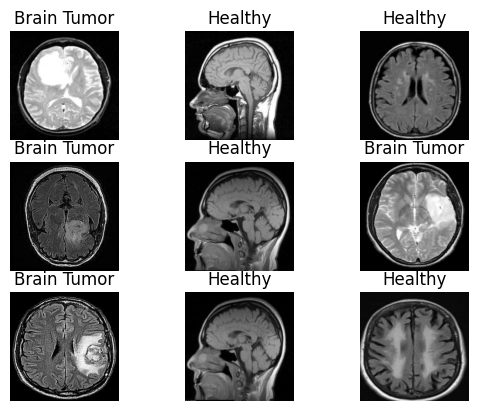

Shape of one image tensor: (224, 224, 3)
Shape of one label tensor: (1,)


In [4]:
plt.figure()
for images, labels in val_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(val_data.class_names[int(labels[i])])
        plt.axis('off')
    plt.show()
    print(f'Shape of one image tensor: {images[0].shape}')
    print(f'Shape of one label tensor: {labels[0].shape}')

## Creating the Deep Learning Model

We are going to create a convolutional neural network and train it using the images from our dataset. This model should take a 224 by 224 image and output a value of 0 if there's no tumor, and 1 if there is a tumor.

In [5]:
# Create a Sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.),  # Rescale pixel value to between 0 and 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='simple_cnn')

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# For faster training we will only use 10 percent of val_data for validation
val_steps = int(0.1*len(val_data))

# We use early stopping to stop training if validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(train_data, epochs=15, validation_data=val_data, validation_steps=val_steps,
                    callbacks=[early_stopping])

Epoch 1/15
113/113 [==============================] - 55s 451ms/step - loss: 0.4676 - accuracy: 0.7663 - val_loss: 0.2738 - val_accuracy: 0.8594
Epoch 2/15
113/113 [==============================] - 53s 466ms/step - loss: 0.2032 - accuracy: 0.9277 - val_loss: 0.1726 - val_accuracy: 0.8906
Epoch 3/15
113/113 [==============================] - 53s 471ms/step - loss: 0.1123 - accuracy: 0.9626 - val_loss: 0.1153 - val_accuracy: 0.9375
Epoch 4/15
113/113 [==============================] - 55s 486ms/step - loss: 0.0464 - accuracy: 0.9903 - val_loss: 0.0822 - val_accuracy: 0.9688
Epoch 5/15
113/113 [==============================] - 54s 471ms/step - loss: 0.0214 - accuracy: 0.9956 - val_loss: 0.0452 - val_accuracy: 0.9688
Epoch 6/15
113/113 [==============================] - 52s 462ms/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.0447 - val_accuracy: 0.9688
Epoch 7/15
113/113 [==============================] - 52s 461ms/step - loss: 0.0134 - accuracy: 0.9975 - val_loss: 0.0542 - val_ac

In [6]:
# Overview of model architecture
model.summary()

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0

## Analyzing Results

With the model trained, it is time to see how it perform on the full validation datset (only 10% was used in training). In addition, we'll visualize how different metrics on different datasets change during training.

In [7]:
# Evaluating model on full validation dataset
eval_loss, eval_acc = model.evaluate(val_data)
print(f'Total model accuracy: {round(eval_acc*100, 2)}%')

29/29 [==============================] - 3s 93ms/step - loss: 0.1368 - accuracy: 0.9745
Total model accuracy: 97.45%


In [8]:
# Generating a confusion matrix
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

y_probs = model.predict(val_data)
y_preds = tf.round(y_probs)
y_true = np.concatenate([y for x, y in val_data], axis=0)
cm = confusion_matrix(y_true, y_preds)
f1s = f1_score(y_true, y_preds)

print('Confusion Matrix:')
print(cm)
print(f'True Positives: {cm[1][1]}')
print(f'True Negatives: {cm[0][0]}')
print(f'False Positives: {cm[0][1]}')
print(f'False Negatives: {cm[1][0]}')
print(f'F1 Score: {f1s}')

29/29 [==============================] - 3s 99ms/step
Confusion Matrix:
[[407  13]
 [ 10 472]]
True Positives: 472
True Negatives: 407
False Positives: 13
False Negatives: 10
F1 Score: 0.9762150982419855


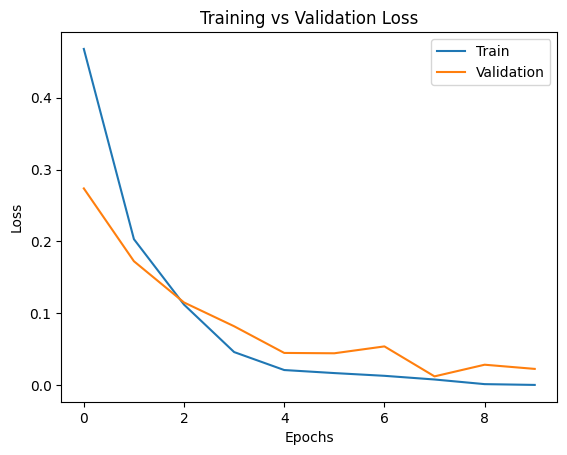

In [9]:
# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

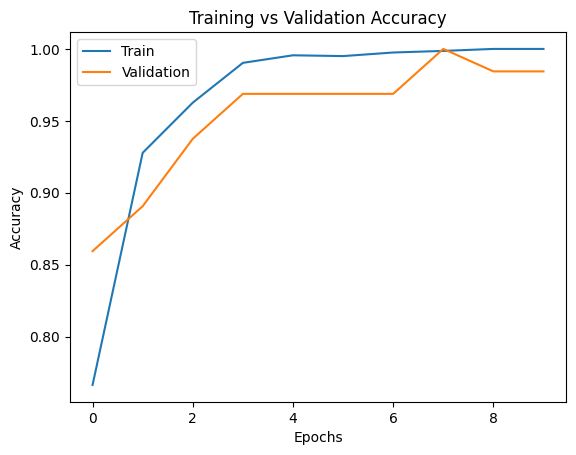

In [10]:
# Plot training accuracy vs validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

From the two graphs above, it seems that slight overfitting occurs around epoch 3.

## Exporting the model

The model will be saved in SavedModel format, so that it can be shared with other people who want to use it to make predictions.

In [11]:
model.save('brain_tumor_detection_model')

INFO:tensorflow:Assets written to: brain_tumor_detection_model\assets


INFO:tensorflow:Assets written to: brain_tumor_detection_model\assets


The cell above will produce a folder called `/brain_tumor_detection/`, which contains all the information needed to reload our model. This format will also allow us to deploy the model in a production environment. <br> <br>
Some warning messages may be displayed from saving the model, but it's fine to ignore this. Just to be sure, we'll reload the model and evaluate it on our data.

In [12]:
loaded_model = tf.keras.models.load_model('brain_tumor_detection_model')
loaded_model.evaluate(val_data)

29/29 [==============================] - 3s 97ms/step - loss: 0.1368 - accuracy: 0.9745


[0.13677068054676056, 0.9745011329650879]

The accuracy on the full validation dataset should be very similar to the original model's. Some floating point errors may lead to tiny discrepancies between the values.